<a href="https://colab.research.google.com/github/Eric-Chung-0511/Learning-Record/blob/main/General%20Helpers/PyTorch/Experiments/Custom_dataset_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn

In [ ]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

## Get Data

* start with 3 classes of food and only 10% of the images

* data_path：用於保存 .zip 文件和其他數據文件的目錄。
* image_path：解壓縮後的文件存放目錄。

In [ ]:
import requests
import zipfile
from pathlib import Path

# setup path to a data folder
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

# If the image folder doesn't exist, download it and prepare it
if image_path.is_dir():
    print(f'{image_path} directory already exist')
else:
    print(f'{image_path} does not exist')
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print('Downloading data...')
    f.write(request.content)

# Unzip the file
with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
    print('Unzipping data...')
    zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exist
Unzipping data...


## Data preparation and exploration

In [ ]:
import os
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directions and {len(filenames)} images in '{dirpath}'.")

In [ ]:
walk_through_dir(image_path)

There are 2 directions and 0 images in 'data/pizza_steak_sushi'.
There are 3 directions and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directions and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directions and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directions and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 3 directions and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directions and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directions and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directions and 19 images in 'data/pizza_steak_sushi/test/steak'.


In [ ]:
# setup train and test paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## Visualize the image

* `glob`: 方法獲取所有符合特定模式的文件路徑

* `stem`: 獲取父目錄的名稱

In [ ]:
image_path

PosixPath('data/pizza_steak_sushi')

Random image path: data/pizza_steak_sushi/train/pizza/1649276.jpg
Image class: pizza
Image height: 384
Image width: 512


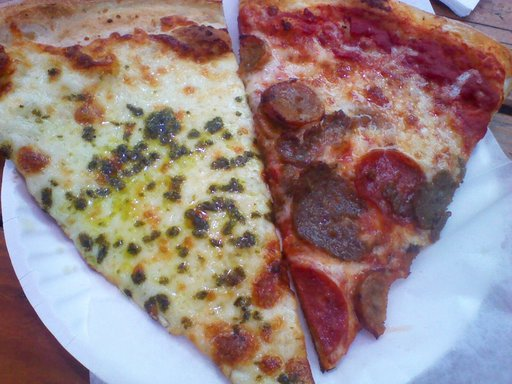

In [ ]:
import random
from PIL import Image

# Get all image paths (* means "any combination")
image_path_list = list(image_path.glob('*/*/*.jpg'))

# get random image path
random_image_path = random.choice(image_path_list)

# get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# open image
img = Image.open(random_image_path)

# print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

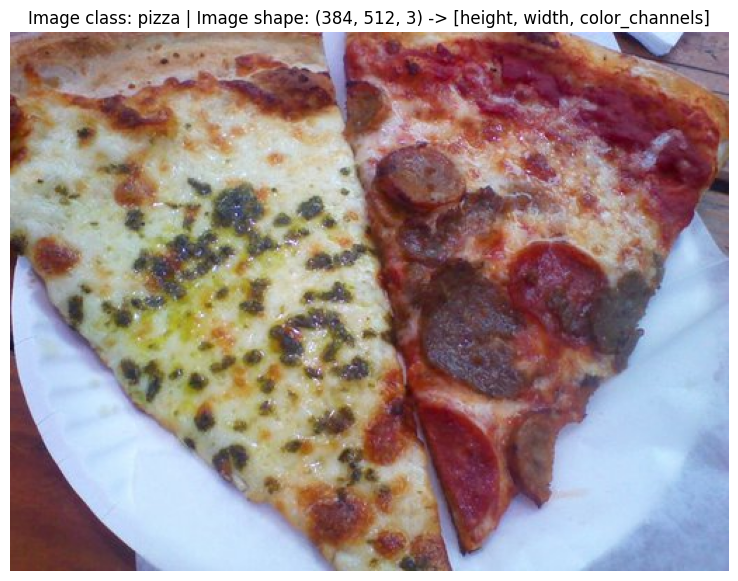

In [ ]:
# We can do the same with matplotlib.pyplot.imshow(), except we have to convert the image to a NumPy array first.
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

## Transforming data

* Before using the image data with PyTorch:
1. Turn target data into tensors
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
data_transform = transforms.Compose([
    # Resize images to 64x64
    transforms.Resize(size=(64, 64)),
    #Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [ ]:
data_transform(img).shape

torch.Size([3, 64, 64])

* PyTorch prefer: [Color_channel, Height, Width]
* Matplotlib prefer: [Height, Width, Color_channel]

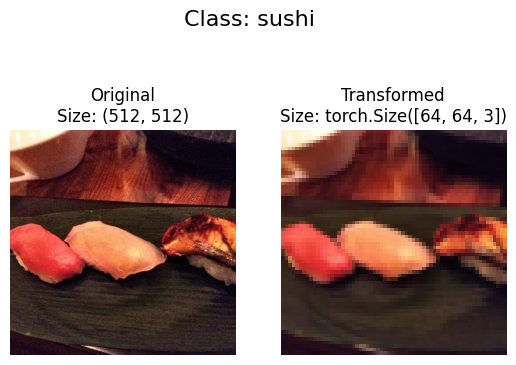

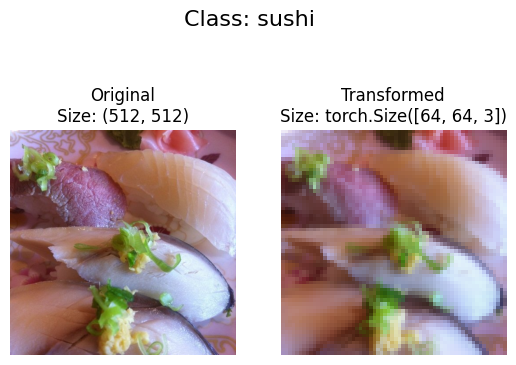

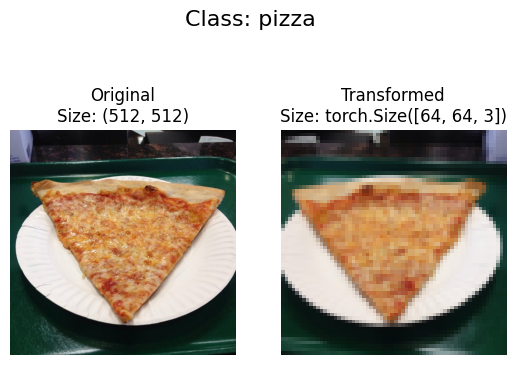

In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n) # n=這是要隨機選擇並顯示的圖像數量，預設為 3
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2) # 1 row 2 columns
            ax[0].imshow(f)
            ax[0].set_title(f'Original\nSize: {f.size}')
            ax[0].axis('off')

            # Transform and plot image
            # permute() will change shape of image to suit matplotlib
            # PyTorch default is [C, H, W], but Matplotlib is [H, W, C]
            transformed_image = transform(f).permute(1, 2, 0) # the original is (3, 64, 64) --> (64, 64, 3), so the index changed the position
            ax[1].imshow(transformed_image)
            ax[1].set_title(f'Transformed\nSize: {transformed_image.shape}')
            ax[1].axis('off')

            fig.suptitle(f'Class: {image_path.parent.stem}', fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3)

## Option 1 Loading Image Data Using `ImageFolder`

In [ ]:
# Use ImageFolder to create dataset
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
# get class name as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
# get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# check the lengths of dataset
len(train_data), len(test_data)

(225, 75)

In [ ]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [ ]:
img, label = train_data[0][0], train_data[0][1]
print(f'Image tensor:\n {img}')
print(f'Imahe shape:\n {img.shape}')
print(f'Image datatype:\n {img.dtype}')
print(f'Image label:\n {label}')
print(f'Image label datatype:\n {type(label)}')

Image tensor:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

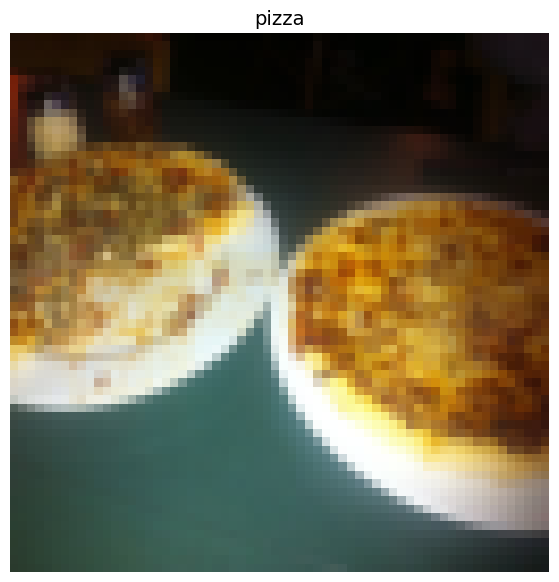

In [ ]:
# rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

# print different shapes
# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# plot image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=14)

In [ ]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader

BATCH_SIZE = 1 # usually 32, 64,..., but now just keep it simple

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1, # os.cpu_count(), use all your cpu
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1, # os.cpu_count(), use all your cpu
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7934c524d510>,
 <torch.utils.data.dataloader.DataLoader at 0x7934c524e920>)

In [ ]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [ ]:
# 從 train_dataloader 中提取一個批次的圖像和對應的標籤。
img, label = next(iter(train_dataloader))

print(f'Image shape: {img.shape} -> [batch_size, color_channels, height, width]')
print(f'Label shape: {label.shape}')

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## Option 2: Loading Image Data with a Custom Dataset

* 創建一個自定義的 Dataset 來加載圖像數據，尤其是在 PyTorch 中。
* 當遇到現有的 Dataset 類（例如 `torchvision.datasets.ImageFolder()`）無法滿足需求時，你可能需要自己構建一個自定義的 Dataset。
* 這樣做的目的是靈活地處理和加載各種數據格式，以便適應不同的任務需求。

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [ ]:
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Create a helper function to get class names

#### 使用 `os.scandir()` 來遍歷目標目錄以獲取類別名稱

* `os.scandir()` 是 Python 的內建函數，它返回一個迭代器，該迭代器產生目標目錄中的每一個 DirEntry 對象。

1. **遍歷目標目錄**:
   使用 `os.scandir()` 函數來遍歷目標目錄，該目錄應該符合標準的圖像分類格式（每個類別的圖像應該放在單獨的子文件夾中）。

2. **檢查類別名稱**:
   檢查是否成功找到類別名稱。如果找不到類別名稱，應該拋出錯誤，這可能表明目錄結構有問題。

3. **生成數字標籤字典**:
   將找到的類別名稱轉換成一個數字標籤字典，其中每個類別對應一個唯一的數字標籤。


In [ ]:
# setup path for target directory
target_directory = train_dir
print(f'Target dir: {target_directory}')

# get the class names from the target directory
# 從目標目錄 (target_directory) 中找到所有的類別名稱，並對它們進行排序
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

#### 這段型別註解 Tuple[List[str], Dict[str, int]] 的意思是函式返回一個元組，這個元組包含了兩個元素：

* 第一個元素是一個 List[str]，也就是一個包含類別名稱的字串列表。
* 第二個元素是一個 Dict[str, int]，也就是一個字典，字典的鍵是類別名稱（字串），值是對應的數字標籤（整數）。

* Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})

In [ ]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    # get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # raise en error if class names could not be found
    if not classes:
        raise FileNotFoundError(f'Could not find any classes in {directory}')

    # create a dictionary of index labels
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

    return classes, class_to_idx

In [ ]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Create a custom Dataset to replicate ImageFolder

#### 子類化 `torch.utils.data.Dataset`

### 自定義數據集類的步驟

1. **繼承 `torch.utils.data.Dataset`**：
   - 這是所有自定義數據集類的基礎。

2. **初始化**：
   - 在 `__init__` 方法中設置數據集的目錄路徑和可選的轉換操作（`transform`）。

3. **定義屬性**：
   - 存儲圖像的路徑列表。
   - 存儲類別名稱及其對應的數字標籤（通常從 `find_classes()` 函數獲取）。
   - 設置可選的圖像轉換操作。

4. **實現 `__len__` 方法**：
   - 返回數據集的總樣本數，以便使用 `len()` 函數檢查數據集的大小。

5. **實現 `__getitem__` 方法**：
   - 根據索引返回數據集中的一個樣本，包括圖像和其對應的標籤。這是數據加載的核心。



In [ ]:
# subclass torch.utils.data.Dataset, (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
    # Initialize custom dataset
    def __init__(self, targ_dir: str, transform=None):
        # create class attribute
        self.paths = list(pathlib.Path(targ_dir).glob('*/*.jpg'))
        self.transform = transform
        # create classes and class_to_idx
        self.classes, self.class_to_idx = find_classes(targ_dir)

        # create function to load images
    def load_image(self, index: int) -> Image.Image:
        # open an image via a path and returns it
        image_path = self.paths[index]
        return Image.open(image_path)

        # overwrite __len__()
    def __len__(self) -> int:
        return len(self.paths)

        # overwrite __getitem__() method to return a particular sample
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img = self.load_image(index)
        class_name = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return untransformed data, label (X, y)

In [ ]:
# Create transform
train_transforms = transforms.Compose([transforms.Resize(size=(64, 64)), transforms.RandomHorizontalFlip(p=0.5), transforms.ToTensor()])
test_transforms = transforms.Compose([transforms.Resize(size=(64, 64)), transforms.ToTensor()])

In [ ]:
# test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir, transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir, transform=test_transforms)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7934c52e7a30>,
 <__main__.ImageFolderCustom at 0x7934c52b2020>)

In [ ]:
len(train_data), len(train_data_custom), len(test_data), len(test_data_custom)

(225, 225, 75, 75)

In [ ]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


### Create a function to display random images

####  圖像顯示功能的分步解釋

目的是構建一個函數，該函數可以接收一個 `Dataset` 對象以及其他參數（如類別名稱、要顯示的圖像數量 `n` 和隨機種子 `seed`），並隨機顯示數據集中的一些圖像。以下是實現這一功能的步驟解釋：

1. **接收數據集和其他參數**：
   - 函數應該能夠接收一個 `Dataset` 對象，類別名稱列表 (`classes`)，要顯示的圖像數量 (`n`)，以及一個隨機種子 (`seed`)。
   - 這樣可以靈活地控制圖像顯示的內容和方式。

2. **限制顯示的圖像數量**：
   - 為了防止顯示過多的圖像導致混亂，將 `n` 限制在最多顯示 10 張圖像。
   - 如果 `n` 超過 10，則強制將其設置為 10。

3. **設置隨機種子**：
   - 如果提供了 `seed`，則設置隨機種子，以保證每次執行時生成相同的隨機圖像列表。
   - 這樣可以保證圖像顯示的可重現性，方便調試和比較。

4. **獲取隨機樣本索引**：
   - 使用 Python 的 `random.sample()` 函數來生成一組隨機的樣本索引。
   - 這些索引用來從數據集中隨機選擇要顯示的圖像。

5. **設置 matplotlib 圖形**：
   - 配置 matplotlib 圖形的布局和大小，以便能夠清晰地顯示選擇的圖像。
   - 根據選擇的圖像數量動態調整顯示布局。

6. **迭代並顯示圖像**：
   - 遍歷隨機樣本索引，並使用 matplotlib 顯示每張圖像。
   - 在顯示圖像時，確保圖像的形狀為 HWC（高度、寬度、顏色通道），這是 matplotlib 顯示圖像所需的格式。


In [ ]:
random_sample_idx = random.sample(range(len(train_data_custom)), k=10)
random_sample_idx

[27, 72, 34, 92, 211, 174, 47, 127, 14, 172]

```python
 for i, targ_sample in enumerate(random_sample_idx):
        target_image, target_label = dataset[targ_sample][0], dataset[targ_sample][1]
```
* i 是迴圈的計數器，從 0 開始，用來標記當前處理的第幾個元素。它與 random_sample_idx 中的元素沒有直接關係，但可以用來控制顯示位置或其他需要計數的邏輯。

* targ_sample 是隨機選擇的數據索引，直接用來從 dataset 中提取數據樣本。

```
假設 random_sample_idx = [5, 3, 7]：

在第一個迴圈中：

i = 0
targ_sample = 5
程式碼會取出 dataset[5] 的內容
```

In [ ]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # Adjust display if n is too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # set the seed
    if seed:
        random.seed(seed)

    # get random samples indexes
    random_sample_idx = random.sample(range(len(dataset)), k=n)

    # setup plot
    plt.figure(figsize=(16, 8))

    # loop through random indexes and plot them
    # targ_sample 是 random_samples_idx 列表中的一個元素，表示某個圖像在 dataset 中的位置索引。
    for i, targ_sample in enumerate(random_sample_idx):
        target_image, target_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # Adjust tensor dimensions for plotting
        targ_image_adjust = target_image.permute(1, 2, 0)

        # plot adjusted samples
        plt.subplot(1, n, i+1) # (row, column, index), python index start from 0
        plt.imshow(targ_image_adjust)
        plt.axis('off')
        if classes:
            title = f'Class: {classes[target_label]}'
            if display_shape:
                title = title + f'\nshape: {targ_image_adjust.shape}'
        plt.title(title)

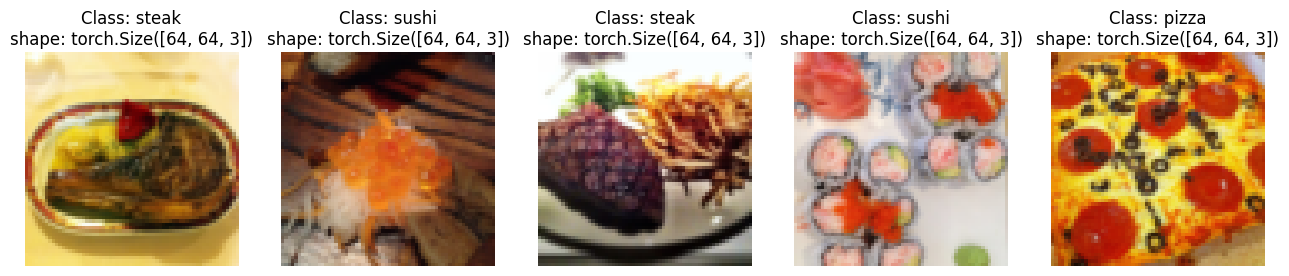

In [ ]:
# Display random images from the ImageFolder
display_random_images(train_data, n=5, classes=class_names, seed=None)

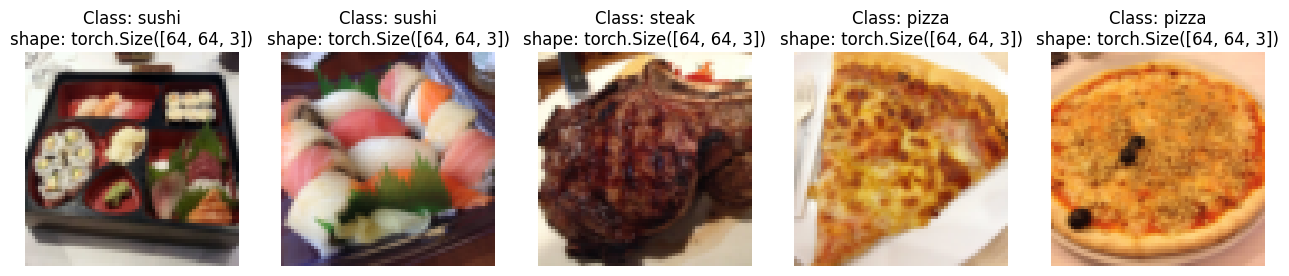

In [ ]:
# Display random images from the ImageFolderCustom Dataset
display_random_images(train_data_custom, n=5, classes=class_names, seed=None)

### Turn custom loaded images into `DataLoader`

In [ ]:
# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader

BATCH_SIZE = 1

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=0,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=0,
                                    shuffle=False)

In [ ]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## Other forms of transforms (data augmentation)

* Using **trivailaugment**

In [ ]:
from torchvision import transforms

train_transforms = transforms.Compose([transforms.Resize(size=(224, 224)),
                                       transforms.TrivialAugmentWide(num_magnitude_bins=5),
                                       transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.Resize(size=(224, 224)),
                                      transforms.ToTensor()])

In [ ]:
image_path

PosixPath('data/pizza_steak_sushi')

In [ ]:
# get all image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/sushi/2175561.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/3251688.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/3004029.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/385154.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/14046.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/710379.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/686426.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/3360232.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2980779.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1551817.jpg')]

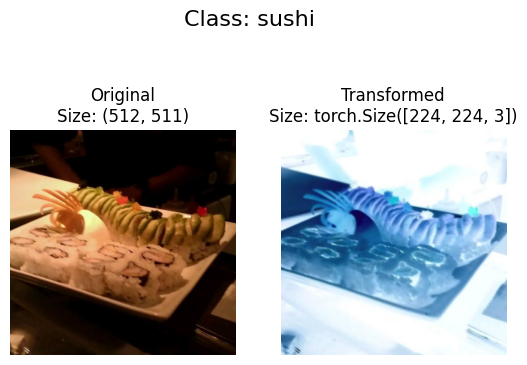

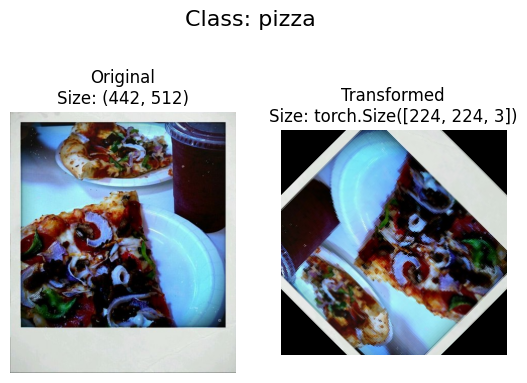

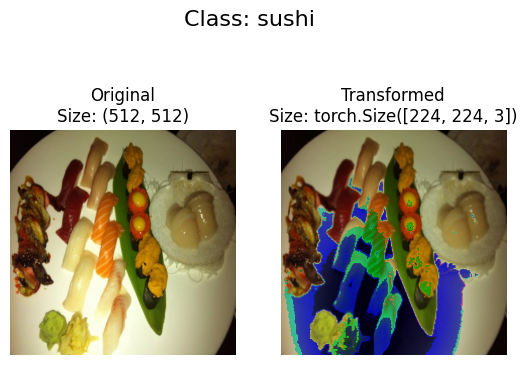

In [ ]:
# plot random transformed images
plot_transformed_images(image_paths=image_path_list,
                        transform=train_transforms,
                        n=3,
                        seed=None)

## 1. Model 0: TinyVGG without data augmentation

### 1.1 Creating transforms and loading data for Model 0

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
simple_transform = transforms.Compose([transforms.Resize(size=(64, 64)),
                                      transforms.ToTensor()])

In [ ]:
# load and transform the data
from torchvision import datasets

train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# turn data into dataloader
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 32 and 2 workers.


(<torch.utils.data.dataloader.DataLoader at 0x7934c506f3a0>,
 <torch.utils.data.dataloader.DataLoader at 0x7934c4e59de0>)

### 1.2 Create TinyVGG model class

In [ ]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # stride=2 is default
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2) # stride=2 is default
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16, out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x
        # or just write return self.classifier(self.conv_block_2(self.conv_block_1(x)))


model_0 = TinyVGG(input_shape=3, # RGB color channel
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

model_0


TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [ ]:
# img_batch, label_batch = next(iter(train_dataloader_simple))
# img_batch.shape, label_batch.shape
# Output:
# (torch.Size([32, 3, 64, 64]), torch.Size([32]))

# model_0(img_batch.to(device))
# Output:
# ---------------------------------------------------------------------------
# RuntimeError                              Traceback (most recent call last)
# <ipython-input-67-efc5a5ef687c> in <cell line: 1>()
# ----> 1 model_0(img_batch.to(device))

# 8 frames
# /usr/local/lib/python3.10/dist-packages/torch/nn/modules/linear.py in forward(self, input)
#     114
#     115     def forward(self, input: Tensor) -> Tensor:
# --> 116         return F.linear(input, self.weight, self.bias)
#     117
#     118     def extra_repr(self) -> str:

# RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x2560 and 10x3) ---> 2560(10*16*16), so nn.Linear(in_features=hidden_units*16*16

## 1.3 Try a forward pass on a single image (to test the model)
* A good way to test a model is to do a forward pass on a single piece of data.

* It's also handy way to test the input and output shapes of our different layers.

* To do a forward pass on a single image.

 **PyTorch 中使用 `unsqueeze(dim=0)` 的目的與作用**

* 在 PyTorch 中，模型通常期望輸入數據具有一個批次維度（batch dimension），即形狀為 `[batch_size, channels, height, width]` 的四維張量。因此，當我們從批次中提取出單張圖像時，我們需要使用 `unsqueeze(dim=0)` 在第 0 維度新增一個維度，來模擬這個批次大小。

#### 核心觀念：
- **模型輸入的期望格式**：
  - 在 PyTorch 中，大多數模型都期望輸入的數據是四維張量，形狀為 `[batch_size, channels, height, width]`。
  - 這其中，第 0 維度表示批次大小（batch size），即一個批次中樣本的數量。

- **單張圖像的初始形狀**：
  - 當從批次中提取出單張圖像時，圖像的形狀通常是三維的，為 `[channels, height, width]`。
  - 此時，缺少批次維度，因為它只代表一張圖像，而不是一個批次。

- **`unsqueeze(dim=0)` 的作用**：
  - `unsqueeze(dim=0)` 的作用是在第 0 維度新增一個維度，使其變成 `[1, channels, height, width]`。
  - 這個新增的 `1` 代表批次大小為 1，即使這張圖像仍然是一個批次中的唯一樣本，也符合模型期望的四維張量格式。

#### 總結：
- **新增一個批次維度**：
  - 使用 `unsqueeze(dim=0)` 可以將單張圖像的形狀從 `[channels, height, width]` 轉換為 `[1, channels, height, width]`，以符合模型所期望的輸入格式。
- **原因**：
  - 這是因為 PyTorch 中的模型通常期望輸入數據具有一個批次維度，這樣即使只處理單張圖像，也能保證數據形狀的正確性和一致性。



In [ ]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[-0.0106,  0.0229,  0.0367]])

Output prediction probabilities:
tensor([[0.3244, 0.3355, 0.3401]])

Output prediction label:
tensor([2])

Actual label:
0


### 1.4 Use `torchinfo` to get an idea of the shapes going through our model

In [ ]:
try:
    import torchinfo
except:
    !pip install torchinfo # # 如果捕捉到 !pip install torchinfo，執行這段
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

### 1.5 Create train & test loop functions

* `train_step()` - takes in a model, a DataLoader, a loss function and an optimizer and trains the model on the DataLoader.
* `test_step()` - takes in a model, a DataLoader and a loss function and evaluates the model on the DataLoader.
* `train()` - performs 1. and 2. together for a given number of epochs and returns a results dictionary.

In [ ]:
# Create train_step()
def train_step(model, dataloader, loss_fn, optimizer):
    model.train()

    # setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # loop through data loader data bactches
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X) # model logits, [batch_size, num_classes]

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        # calculate accuracy metric
        y_pred_labels = y_pred.argmax(dim=1)
        train_acc += (y_pred_labels==y).sum().item() / len(y_pred_labels) # y_pred_labels==y : 將預測結果與真實標籤進行比較，計算正確預測的數量

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc

In [ ]:
# Create test_step()
def test_step(model, dataloader, loss_fn):
    model.eval()

    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred = model(X)

            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred.argmax(dim=1)
            test_acc += (test_pred_labels==y).sum().item() / len(test_pred_labels)

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)

        return test_loss, test_acc

### 1.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [ ]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs=5):

    # create empty dictionary for tracking
    results = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

    # loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn=loss_fn, optimizer=optimizer)
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn=loss_fn)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # update results
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    return results

### 1.7 Train and Evaluate Model 0

In [ ]:
NUM_EPOCHS = 5

model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(train_data.classes)).to(device)

# setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.01)

# calculate time
from timeit import default_timer as timer
start_time = timer()

# train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer
end_time = timer()
print(f'Total training time: {end_time - start_time:.3f} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.4325 | train_acc: 0.3281 | test_loss: 1.0980 | test_acc: 0.4706
Epoch: 2 | train_loss: 1.0999 | train_acc: 0.3047 | test_loss: 1.0995 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.1007 | train_acc: 0.3047 | test_loss: 1.1040 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.0996 | train_acc: 0.3047 | test_loss: 1.1002 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0988 | train_acc: 0.2930 | test_loss: 1.0951 | test_acc: 0.5417
Total training time: 18.743 seconds


### 1.8 Plot the loss curves of Model 0

In [ ]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [ ]:
def plot_loss_curves(results):
    # Get the loss values of the results dictionary (training and test)
    train_loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    train_acc = results['train_acc']
    test_acc = results['test_acc']

    # Figure out how many epochs there were, 使用range, 創建了一個可迭代的範圍對象，可以在繪圖時逐一迭代每一個 epoch 的數據
    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))

    # plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='train_accuracy')
    plt.plot(epochs, test_acc, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    plt.show()

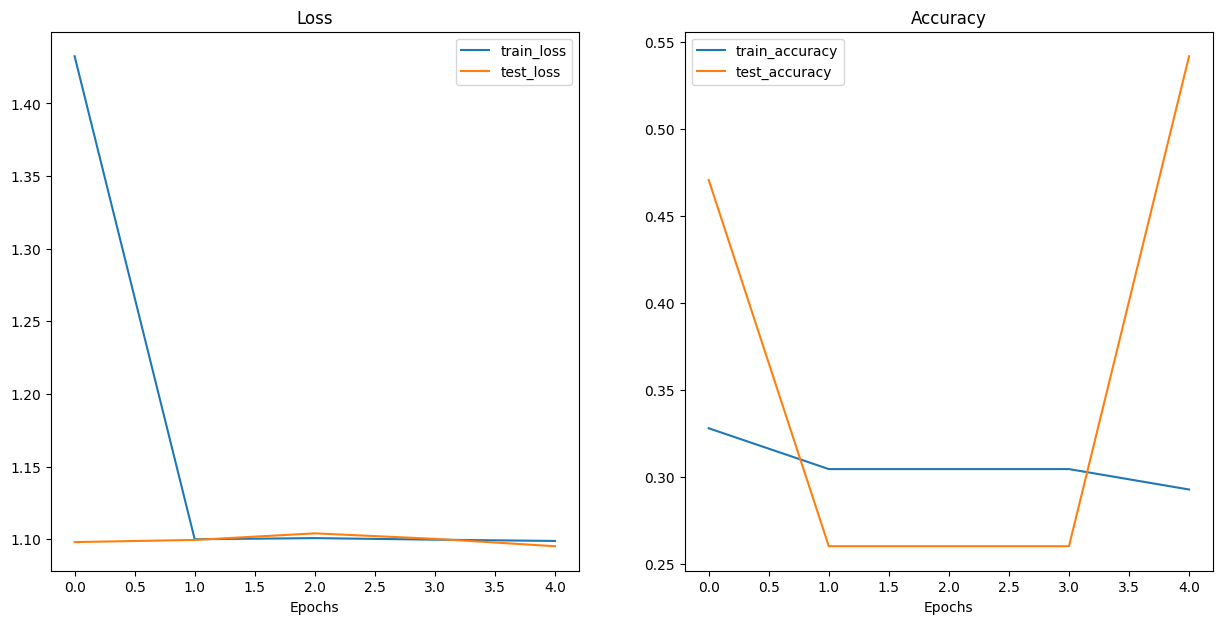

In [ ]:
plot_loss_curves(model_0_results)

## 2. Model 1: TinyVGG with Data Augmentation


### 2.1 Create transform with data augmentation

In [ ]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([transforms.Resize(size=(64, 64)),
                                                      transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                                      transforms.ToTensor()])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([transforms.Resize(size=(64, 64)),
                                     transforms.ToTensor()])

### 2.2 Create train and test Dataset's and DataLoader's

In [ ]:
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [ ]:
# Turn Datasets into DataLoader's
import os

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        num_workers=NUM_WORKERS,
                                        shuffle=True)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

train_dataloader_augmented, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x7934b0b259f0>,
 <torch.utils.data.dataloader.DataLoader at 0x7934b0b26d70>)

### 2.3 Construct and train Model 1

In [ ]:
# Create model_1 and send it to the target device
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [ ]:
EPOCHS = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.01)

start_time = timer()

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1027 | train_acc: 0.3047 | test_loss: 1.1063 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0961 | train_acc: 0.4258 | test_loss: 1.0996 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.1020 | train_acc: 0.3047 | test_loss: 1.1004 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.0998 | train_acc: 0.3047 | test_loss: 1.1055 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0963 | train_acc: 0.3047 | test_loss: 1.1120 | test_acc: 0.2604
Total training time: 14.233 seconds


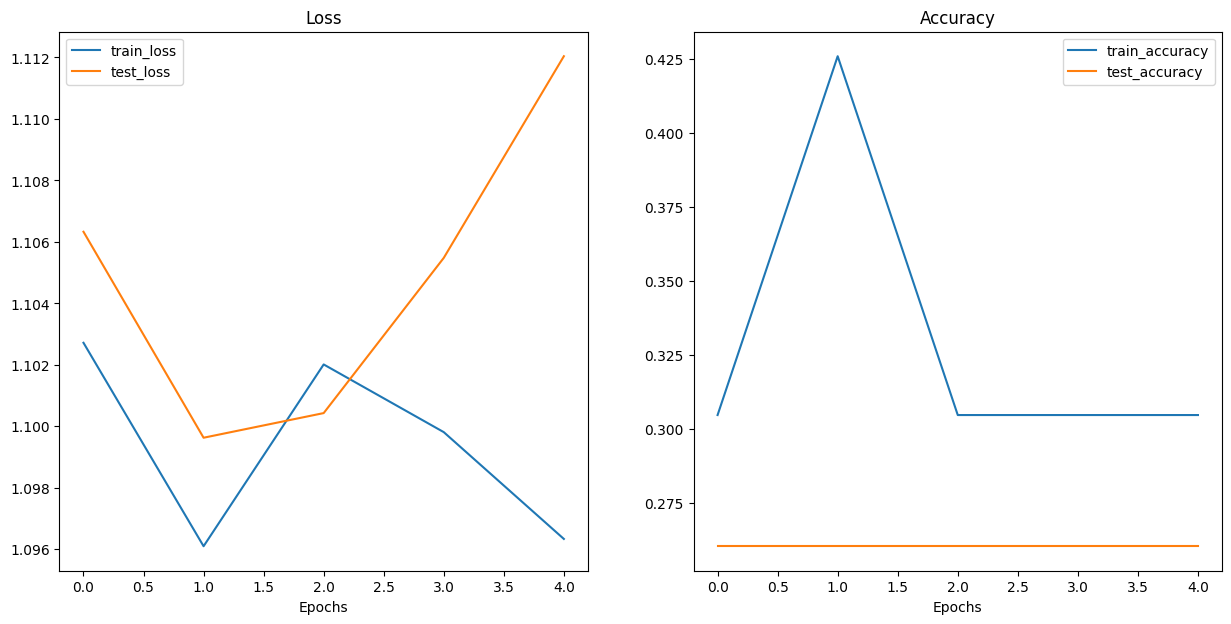

In [ ]:
plot_loss_curves(model_1_results)

### Compare Model results

In [ ]:
import pandas as pd

model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.432472,0.328125,1.097980,0.470644
1,1.099926,0.304688,1.099464,0.260417
2,1.100710,0.304688,1.103986,0.260417
3,1.099647,0.304688,1.100213,0.260417
4,1.098756,0.292969,1.095132,0.541667


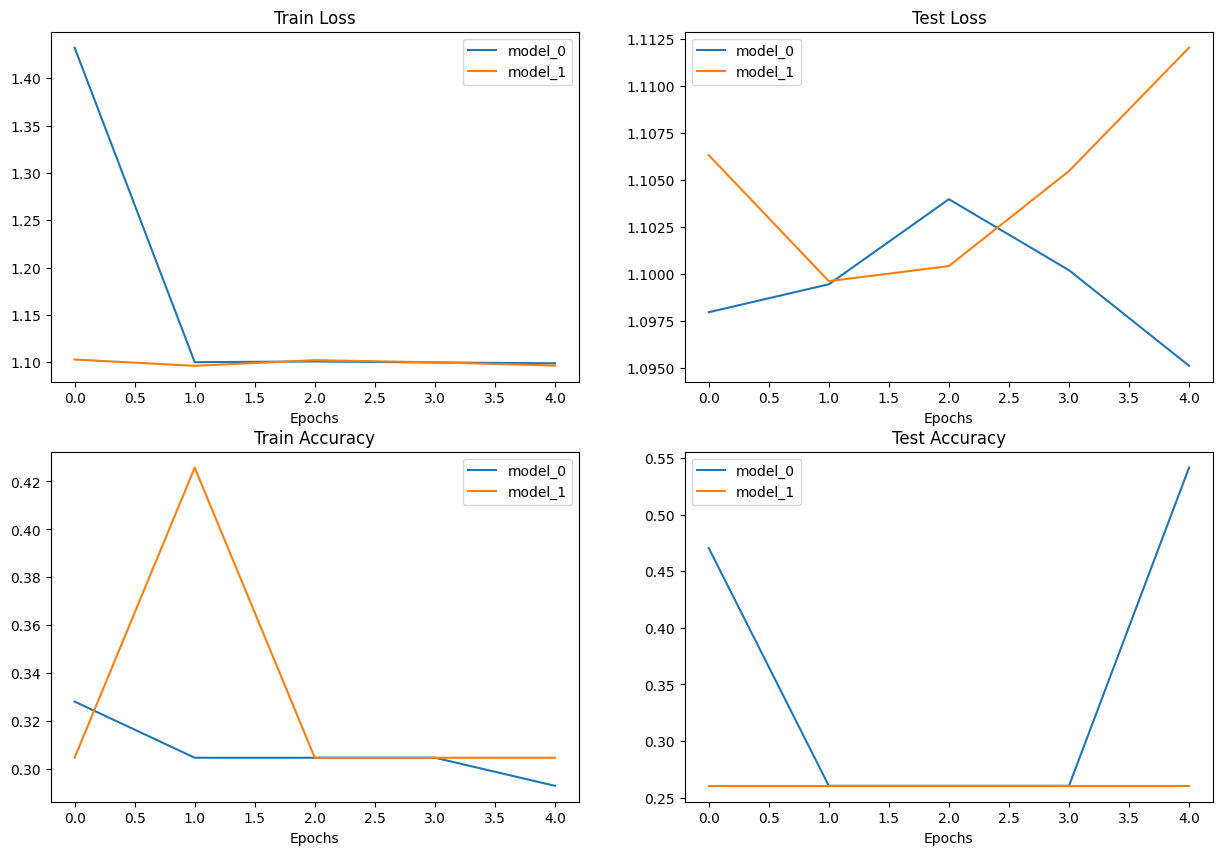

In [ ]:
plt.figure(figsize=(15, 10))

epochs = range(len(model_0_df))

# plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df['train_loss'], label='model_0')
plt.plot(epochs, model_1_df['train_loss'], label='model_1')
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.legend()

# plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df['test_loss'], label='model_0')
plt.plot(epochs, model_1_df['test_loss'], label='model_1')
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.legend()

# plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df['train_acc'], label='model_0')
plt.plot(epochs, model_1_df['train_acc'], label='model_1')
plt.title('Train Accuracy')
plt.xlabel('Epochs')
plt.legend()

# plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df['test_acc'], label='model_0')
plt.plot(epochs, model_1_df['test_acc'], label='model_1')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.show()

## Make a prediction on a custom image

In [ ]:
# Download custom image
import requests

# setup custom image path
custom_image_path = data_path / '04-pizza-dad.jpeg'

# download the image if if does not exist
if not custom_image_path.is_file():
    with open(custom_image_path, 'wb') as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
     print(f"{custom_image_path} already exists, skipping download.")

### Loading in a custom image with PyTorch

* Reads a JPEG, PNG or GIF image into a 3 dimensional RGB or grayscale Tensor. Optionally converts the image to the desired format. The values of the output tensor are uint8 in [0, 255].

According from https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html

In [ ]:
import torchvision

# read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dty

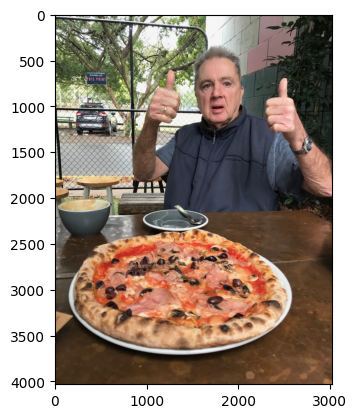

In [ ]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255

plt.imshow(custom_image.permute(1, 2, 0))

In [ ]:
# create transform pipeline to resize shape
custom_image_transform = transforms.Compose([transforms.Resize(size=(64, 64))])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

print(f'Original shape: {custom_image.shape}')
print(f'Transformed shape: {custom_image_transformed.shape}')

Original shape: torch.Size([3, 4032, 3024])
Transformed shape: torch.Size([3, 64, 64])


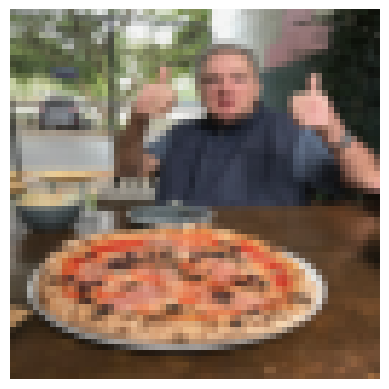

In [ ]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))
plt.axis('off')
plt.show()

In [ ]:
model_1.eval()
with torch.inference_mode():
    # if no unsqueeze(dim=0), it will cause
    # Runtime Error: mat1 and mat2 shapes cannot be multipled (10x256 and 2560x3)
    # it means need a batch_size, so need to unsqueeze it
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

# ['pizza', 'steak', 'sushi']
custom_image_pred

tensor([[ 0.0195,  0.0180, -0.0438]])

In [ ]:
# 1 is batch_size
custom_image_transformed.shape, custom_image_transformed.unsqueeze(dim=0).shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [ ]:
# convert logits to prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.3405, 0.3400, 0.3196]])

In [ ]:
# turn to prediction label
custom_image_pred_labels = custom_image_pred_probs.argmax(dim=1).cpu()
custom_image_pred_labels

tensor([0])

## Putting custom image prediction together: building a function

In [ ]:
def pred_and_plot_image(model, image_path, class_names, transform=None, device=device):

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(image_path).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. make sure the image is on the right device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add extra dimension, batch_size
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_labels = target_image_pred_probs.argmax(dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_labels.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_labels} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis('off')

plt.show()


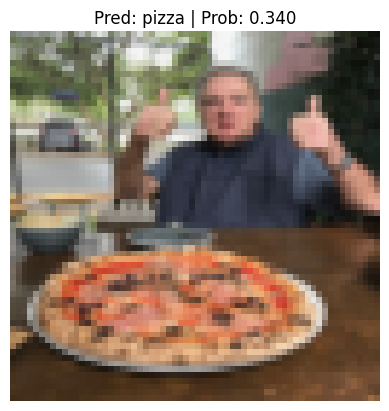

In [ ]:
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)